# Working with Navigation Meshes

##### Last Updated: December 31, 2021

Navigation meshes are a data structure which encode information about a space in a 3D world. Typically, they're used for helping bots navigate through that world. Essentially, these navigation meshes are graphs, where a navigable region of the map (a "tile") is connected to others (the edges on the graph). 

In CSGO, a navigation mesh comes in the form of a `.nav` file. In our library, we provide the navigation mesh information for the most popular maps. If a map is missing, feel free to open up a [feature request](https://github.com/pnxenopoulos/awpy/issues) on Github issues. The map data is found in the `awpy.data` module. The main pieces of data are outlined below. After outlining the data, we show how we can use navigation meshes to calculate distances in CSGO.

### `from awpy.data import MAP_DATA`

`MAP_DATA` is a JSON which contains information that is used to scale coordinates for visualization. The top-level keys are maps, and the objects contained within have an `x`, `y` and `scale` key. An example looks like:

```
{
    ...,
    "de_dust2": {
        "x": -2476,
        "y": 3239,
        "scale": 4.4
    },
    ...
}
```

### `from awpy.data import NAV_CSV`

`NAV_CSV` is a Pandas dataframe containing navigation mesh information. The main components are the map, area id, area name, and the northwest and southeast coordinates of the mesh surface. Sometimes, the area name may be an empty string. One option to infer the area name could be to find the closest tiles and see what the consensus is between them.

In [1]:
from awpy.data import NAV_CSV

NAV_CSV[NAV_CSV["mapName"] == "de_dust2"].head()

,mapName,areaId,areaName,northWestX,northWestY,northWestZ,southEastX,southEastY,southEastZ
5577,de_dust2,8773,BombsiteA,800.0,2400.0,127.031250,825.0,2425.0,127.031250
5578,de_dust2,1442,LongDoors,625.0,600.0,0.471580,650.0,650.0,1.535376
5579,de_dust2,3765,BombsiteB,-2050.0,1950.0,1.638456,-2025.0,2025.0,0.163017
5580,de_dust2,7518,BDoors,-1200.0,2625.0,57.824059,-1125.0,2700.0,85.663452
5581,de_dust2,6608,OutsideTunnel,-1325.0,275.0,7.367699,-1300.0,300.0,8.031246


### `from awpy.data import NAV`

`NAV` is the JSON format of `NAV_CSV`. The structure is `NAV[map_name][area_id]`. We show an example below of what the output looks like.

In [2]:
from awpy.data import NAV

NAV["de_dust2"][152]

{'areaName': 'BombsiteA',
 'northWestX': 1050.0,
 'northWestY': 2325.0,
 'northWestZ': 96.03125,
 'southEastX': 1125.0,
 'southEastY': 2425.0,
 'southEastZ': 96.03125}

Next, we can plot the navigation mesh by using our library's built-in plotting functions.

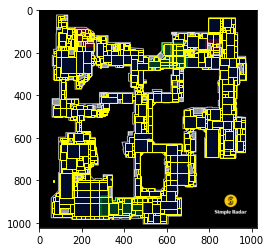

In [3]:
from awpy.visualization.plot import plot_map, position_transform
from matplotlib import patches

f, ax = plot_map(map_name = "de_dust2", map_type = 'simpleradar', dark = True)

for a in NAV["de_dust2"]:
    area = NAV["de_dust2"][a]
    area["southEastX"] = position_transform("de_dust2", area["southEastX"], "x")
    area["northWestX"] = position_transform("de_dust2", area["northWestX"], "x")
    area["southEastY"] = position_transform("de_dust2", area["southEastY"], "y")
    area["northWestY"] = position_transform("de_dust2", area["northWestY"], "y")
    width = (area["southEastX"] - area["northWestX"])
    height = (area["northWestY"] - area["southEastY"])
    southwest_x = area["northWestX"]
    southwest_y = area["southEastY"]
    rect = patches.Rectangle((southwest_x,southwest_y), width, height, linewidth=1, edgecolor="yellow", facecolor="None")
    ax.add_patch(rect)

As described in "[Valuing Player Actions in Counter-Strike: Global Offensive](https://arxiv.org/pdf/2011.01324)", we can use navigation meshes to calculate distances. In the paper, they describe a graph-based distance metric. Essentially, we transform the navigation mesh into a graph where nodes are tiles and edges are created between adjacent tiles. Then, we calculate the distance between two tiles by counting the number of tiles in the shortest path between them.

In [4]:
from awpy.analytics.nav import area_distance

graph_dist = area_distance(map_name="de_dust2", area_a=152, area_b=8970, dist_type="graph")
graph_dist

{'distanceType': 'graph',
 'distance': 30,
 'areas': [152,
  1213,
  8672,
  8677,
  8670,
  1835,
  9020,
  8821,
  1801,
  1384,
  8489,
  5222,
  5253,
  5237,
  6699,
  6700,
  6715,
  6698,
  6695,
  5225,
  5226,
  5221,
  1713,
  1714,
  1077,
  1263,
  7350,
  1421,
  1418,
  1074,
  8970]}

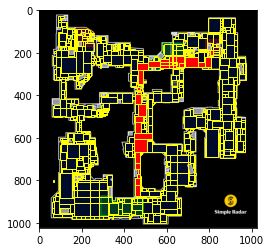

In [5]:
f, ax = plot_map(map_name = "de_dust2", map_type = 'simpleradar', dark = True)

for a in NAV["de_dust2"]:
    area = NAV["de_dust2"][a]
    color = "None"
    if a in graph_dist["areas"]:
        color = "red"
    width = (area["southEastX"] - area["northWestX"])
    height = (area["northWestY"] - area["southEastY"])
    southwest_x = area["northWestX"]
    southwest_y = area["southEastY"]
    rect = patches.Rectangle((southwest_x,southwest_y), width, height, linewidth=1, edgecolor="yellow", facecolor=color)
    ax.add_patch(rect)

However, we know that not all navigation mesh tiles are the same size. Perhaps we want to weight what tiles we choose by their size (diagonal length). We can use "geodesic" distance to calculate a new path, since it is a rough geodesic-esque distance.

In [6]:
from awpy.analytics.nav import area_distance

geodesic_dist = area_distance(map_name="de_dust2", area_a=152, area_b=8970, dist_type="geodesic")

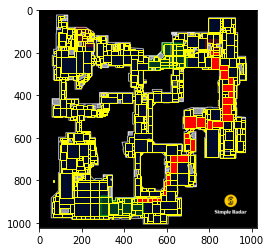

In [7]:
f, ax = plot_map(map_name = "de_dust2", map_type = 'simpleradar', dark = True)

for a in NAV["de_dust2"]:
    area = NAV["de_dust2"][a]
    color = "None"
    if a in geodesic_dist["areas"]:
        color = "red"
    width = (area["southEastX"] - area["northWestX"])
    height = (area["northWestY"] - area["southEastY"])
    southwest_x = area["northWestX"]
    southwest_y = area["southEastY"]
    rect = patches.Rectangle((southwest_x,southwest_y), width, height, linewidth=1, edgecolor="yellow", facecolor=color)
    ax.add_patch(rect)

The distance functions above rely on the `find_closest_area(map_name, point)` and `point_in_area(map_name, area_id, point)` functions. The graph-based distance measures rely on the `networkx` graph objects held in `from awpy.data import NAV_GRAPHS`. You can access the networkx graph (which is another representation of the navigation mesh) for a given map, say Dust 2, via `NAV_GRAPHS["de_dust2"`.